
---



# From linear regression to non-parametric nonlinear regression

In this post, we build up some intuition around how deep learning can be used for approximating any function. We start off with recalling how linear regression is performed and then motivate and demonstrate how a neural network can be used for non-parametric nonlinear regression.

### Install dependencies

In [156]:
import numpy as np
import matplotlib.pyplot as plt

In [157]:
!pip install einops
import einops

In [158]:
import torch
import torch.nn as nn

## Linear Regression

Lets create some sample data that can be modeled with an affine function of x. We choose a pair of ground truth weights from which we'll add some Gaussian noise.

In [159]:
params = np.array([5, 2])

num_samples = 100
x = np.linspace(-10,10,num_samples)

np.random.seed(5)
noise = np.random.normal(0, 3, num_samples)
y = params[0]*x + params[1] + noise

### Fitting a linear model with linear algebra

Recall we can do linear regression by solving a system of equations with the matrix pseudoinverse:

$w = (X^TX)^{-1}X^Ty$

where $y$ is a column vector of the y data points, $X$ is a matrix of the x data points in a column stacked with a column of ones, and $w$ is a $2x1$ vector for the slope and bias of the linear function to estimate.

In [160]:
X = np.stack((x, np.ones(len(x))), axis=1)
weights = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose().dot(y))
print(weights)

[5.00396765 2.27463993]


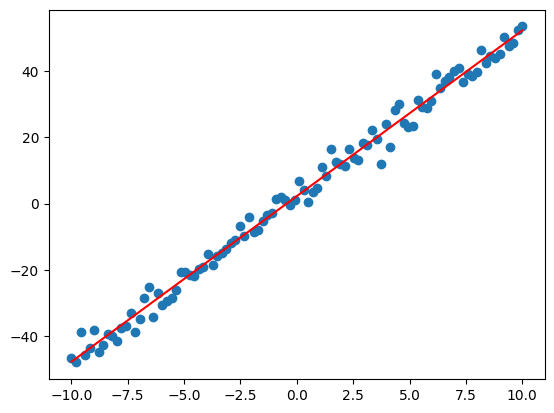

In [161]:
plt.scatter(x,y)
plt.plot(x, weights[0]*x + weights[1], 'r')
plt.show()

Notice we can approximately recover the target slope and bias from which the sample data was generated (not exactly the same since we added noise).

However, we're not always going to be able to find the optimal weights and biases of a model by inverting a matrix. Lets turn to numerical methods for unconstrained optimization (we'll just use gradient descent here, and will explore other methods in a separate post).

### Fitting a linear model using numerical methods

Fitting a linear model with a quadratic loss function is an unconstrained convex optimization problem (least sqares optimization). There should be a single local minimum which is also the global minimum.


We set up the problem as follows with mean squared error loss (MSE):

$f(w) = xw_0 + w_1$


$ w* = \underset{w}{\operatorname{argmin}} || Xw - y ||_2^2$

where $X \in ℝ^{Nx2}, w \in ℝ^2, y \in ℝ^N$. Note the second column of $X$ is a column of ones to be multiplied by the second weight element (the bias term).

$ L= \frac{1}{N} \sum_{i=1}^N( X_iw - y_i )^2$

We need the gradients in order to do gradient descent:

$\frac{dL}{dw} = \frac{dL}{df}\frac{df}{dw} = \frac{2}{N} \sum_{i=1}^N ( X_iw - y_i ) X_i$.


#### Loss function, gradients, optimizer, and trainer

Lets create some reusable components for calculating loss and taking a gradient descent step.

The linear function $f(w)$ and its gradient function $\frac{df}{dw}$ should be familiar.

The MSE loss should also be famliar. We also define a gradient for the MSE Loss. Note that taking the mean is left out. Recall that the mean operation is commutative. This is intended to be applied for backpropagating a batch of values, so we must remember to apply the mean at the end of the backpropagation.

In [162]:
def linear(X, w):
  return X @ w

def linear_grad(X, w):
  return X

In [163]:
def mse_loss(predictions, labels):
  return np.mean((predictions - labels)**2)

def mse_loss_grad(predictions, labels):
  return 2 * (predictions - labels) / len(predictions)

In [164]:
class GradientDescentOptimizer:
  def __init__(self, weights, lr):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]

  def step(self, grad):
    # Update weights
    self.weights -= einops.rearrange(self.lr * grad, 'i j -> (i j)')
    # Keep track of weights for visualization
    self.iterated_weights.append(weights.copy())

  def get_weights(self):
    return self.iterated_weights

In [165]:
class LinearModelTrainer:
  def __init__(self, optimizer, num_epochs):
    self.optimizer = optimizer
    self.epochs = num_epochs
    self.losses = []
    self.final_grad = None

  def train(self):
    for i in range(self.epochs):
      # Make predictions
      preds = linear(X, weights)

      # Calculate loss
      loss = mse_loss(preds, y)
      self.losses.append(loss)

      # Backpropagate
      mse_grad = einops.repeat(mse_loss_grad(preds, y), 'i -> i 1')
      lin_grad = linear_grad(X, weights)
      grad = mse_grad.transpose() @ lin_grad

      # Update weights
      self.optimizer.step(grad)

    # Keep track of final grad for observability
    self.final_grad = grad

  def get_grad(self):
    if self.final_grad is not None:
      return self.final_grad
    else:
      print("No gradients computed yet.")

  def get_losses(self):
    return self.losses



#### Finding optimal slope and bias of a linear function

Lets choose a pair of ground truth weights from which we'll add some Gaussian noise. Lets also initialize a pair of random weights from which to start iterating.

(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
(1, 2)
(2,)
final weights:  [5.00391816 1.16349805]
final grads:  [[-0.01052422 -2.26763649]]


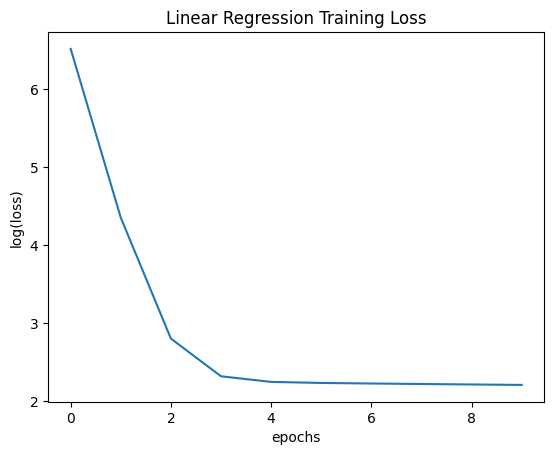

In [166]:
lr = 0.01
num_epochs = 10

# random initialization
weights = np.random.rand(2,)

optimizer = GradientDescentOptimizer(weights, lr)

trainer = LinearModelTrainer(optimizer, num_epochs)
trainer.train()

print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

plt.plot(range(num_epochs), np.log(trainer.get_losses()))
plt.xlabel('epochs')
plt.ylabel('log(loss)')
plt.title('Linear Regression Training Loss')
plt.show()

If our weights are optimal, our gradients should be close to 0. Since the gradient of the second weight is not very close to 0, we know we have room for improvement. However, our rate of descreasing our loss has slowed, so it would take many more epochs to get close to the optimum. We can visualize how we've traversed the search space with gradient descent in the plot below.

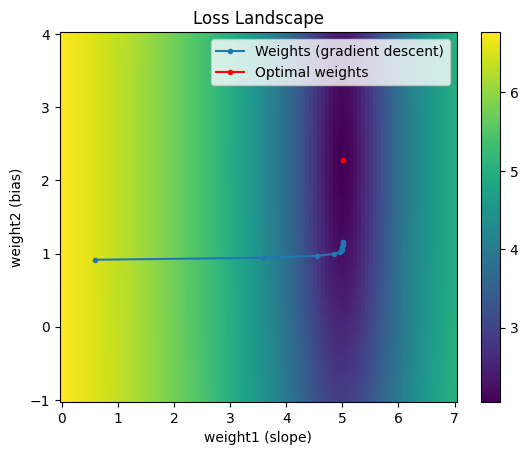

In [167]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (gradient descent)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Notice the weights initially change quickly in the direction of the "trough" but once it reaches that region, it doesn't update very much per step. There are various categories of ways to help us converge faster to the optimum: Input normalization, learning rate scheduling / adaptive learning rates, and different optimizers. We'll explore them in a separate post.

Let's see how well our optimized weights fit the data:

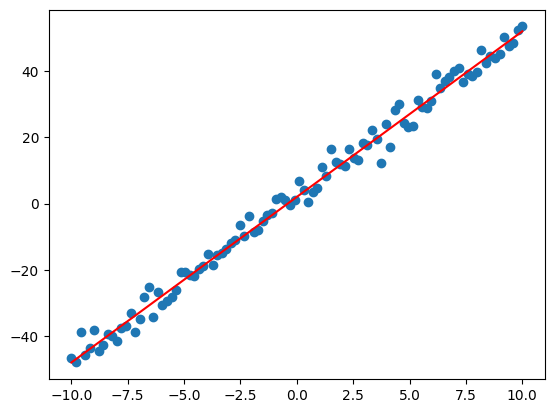

In [168]:
plt.scatter(x,y)
plt.plot(x, weights[0]*x + params[1], 'r')
plt.show()

## Parametric regression

#### Fitting a cubic polynomial

We can also fit any polynomial with a linear model since they are linear in their parameters. Lets sample some data from a cubic polynomial (plus Gaussian noise) defined by the params below.

In [169]:
params = np.array([-1, 3, 5, -9])

num_samples = 100
x = np.linspace(-5,5,num_samples)

np.random.seed(5)
noise = np.random.normal(0, 10, num_samples)
X = np.stack((x**3, x**2, x, np.ones(len(x))), axis=1)
y = X @ params + noise


We set up the problem as follows with mean squared error loss (MSE):

$f(w) = x^3w_0 + x^2w_1 + xw_2 + w_3$


$ w* = \underset{w}{\operatorname{argmin}} || Xw - y ||_2^2$

where $X \in ℝ^{Nx4}, w \in ℝ^4, y \in ℝ^N$.

Notice the problem formulation is exactly the same as before. The difference is that the terms in each row of $X$ are $x_i^k$ for $k \in {3,2,1,0}$ instead of $k \in {1,0}$.

$ L= \frac{1}{N} \sum_{i=1}^N( X_iw - y_i )^2$

We need the gradients in order to do gradient descent:

$\frac{dL}{dw} = \frac{2}{N} \sum_{i=1}^N ( X_iw - y_i ) X_i$.

Notice this polynomial regression problem is quite sensitive to learning rate because its loss function has high curvature due to the higher exponent terms.


(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
(1, 4)
(4,)
final weights:  [-0.73566514  2.27726011  0.13369856  0.97825891]
final grads:  [[  0.79271711 -27.93875074 -14.42952591   5.74386033]]


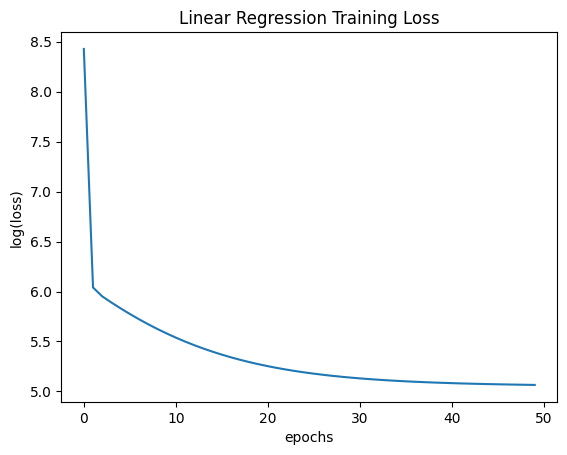

In [170]:
lr = 0.0002
num_epochs = 50

# random initialization
weights = np.random.rand(4,)

optimizer = GradientDescentOptimizer(weights, lr)

trainer = LinearModelTrainer(optimizer, num_epochs)
trainer.train()

print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

plt.plot(range(num_epochs), np.log(trainer.get_losses()))
plt.xlabel('epochs')
plt.ylabel('log(loss)')
plt.title('Linear Regression Training Loss')
plt.show()

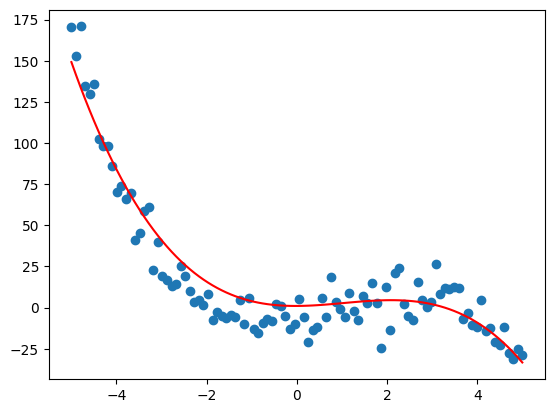

In [171]:
plt.scatter(x,y)
plt.plot(x, X @ weights, 'r')
plt.show()

This linear formulation can be extended to multiple variables as well, but let's move on to non-parametric regression.

## Non-parametric nonlinear regression

### Approximating a nonlinear function

In the examples above, we assumed knowledge of the form of the function we were fitting. Now we remove that assumption and try to fit the data. We can no longer rely simply on estimating the weights of a linear function; instead, we must use many more parameters and a nonlinear activation function.

Lets try to fit data from a quadratic function.

In [172]:
from functools import partial

def f(x, a, b, c):
  return a*x**2 + b*x + c

parabola = partial(f, a=2, b=3, c=5)

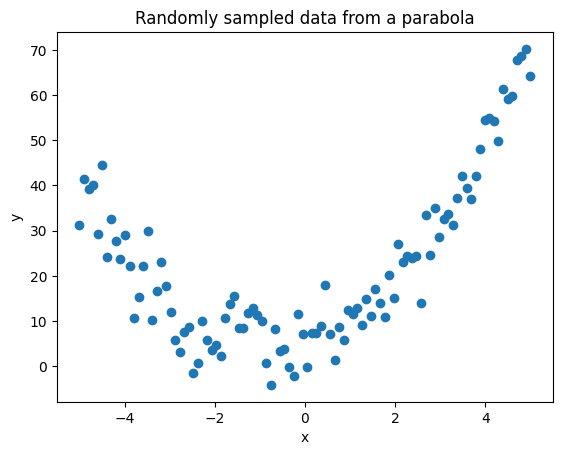

In [173]:
x = np.linspace(-5,5,100)
y = parabola(x) + np.random.normal(0,5,100)

plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Randomly sampled data from a parabola')
plt.show()

In [174]:
X = torch.Tensor(x).view(-1,1)
Y = torch.Tensor(y).view(-1,1)

Now, if we knew or could guess that the data would be best fit by a quadratic function with three weights, we could simply go ahead and take the same approach as above. However, lets pretend we don't know that and try to fit the function with a polyline (affine functions of x that are active within specific regions).

A simple way to make a linear function $f(x)$ only active within a particular region is to use a Rectified Linear Unit (ReLU), which is effectively $max(f(x),0)$. As we increase the number of linear units activated by ReLUs, we gain more flexibility with the number of line segments in our polyline, and can do a better job fitting the sampled data.

Check out this [notebook](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) for expanded coverage on how ReLUs + Linear layers can approximate any function.

In [175]:
def MLP(width):
  return nn.Sequential(nn.Linear(1, width), nn.ReLU(), nn.Linear(width, 1))

We'll take advantage of PyTorch's autograd functionality for simplicity. It operates on `torch.Tensor` objects to backpropagate the gradients.

PyTorch also comes with modules for loss functions and optimizers. Instead of the ones we've already defined, we use theirs to deal with model weights for all layers. We'll do a deeper dive into backpropagation and autograd in another post.

With more neurons, we haev the flexibility to fit the data better, but we are also more prone to overfitting. We use Adam as our optimizer (gradient descent plus some second order approximations) with a weight decay term to penalize large weights. This helps the model output function approximations that fit more nicely. Learning rate and the number of epochs also need to be tuned to get reasonable output.

In [176]:
def train(model, lr, epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=3.0)
  for epoch in range(epochs):
    pred = model(X)
    loss = nn.functional.mse_loss(pred, Y)
    loss.backward()
    optimizer.step()

In [177]:
lr = 5e-4
epochs = 3000

In [178]:
model_2 = MLP(2)
train(model_2, lr, epochs)

In [179]:
model_20 = MLP(20)
train(model_20, lr, epochs)

In [180]:
model_100 = MLP(100)
train(model_100, lr, epochs)

In [181]:
model_1000 = MLP(1000)
train(model_1000, lr, epochs)

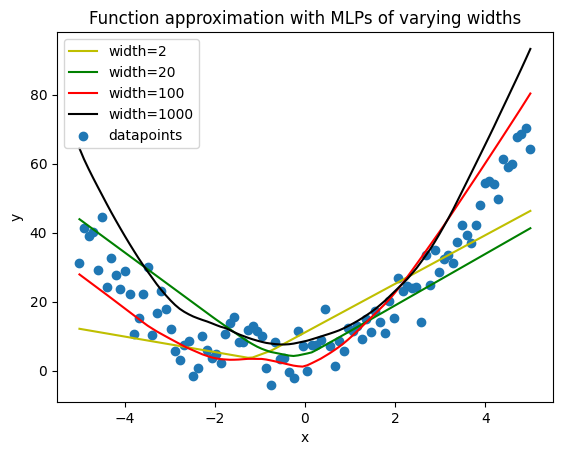

In [182]:
with torch.no_grad():
  preds_2 = model_2(X)
  preds_20 = model_20(X)
  preds_100 = model_100(X)
  preds_1000 = model_1000(X)
plt.plot(X.numpy(), preds_2.numpy(), 'y', label='width=2')
plt.plot(X.numpy(), preds_20.numpy(), 'g', label='width=20')
plt.plot(X.numpy(), preds_100.numpy(), 'r', label='width=100')
plt.plot(X.numpy(), preds_1000.numpy(), 'k', label='width=1000')

plt.scatter(x,y, label='datapoints')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function approximation with MLPs of varying widths')
plt.legend()
plt.show()